# Chapter 13

### Listing 13.1 Inspecting the data of the Jena weather dataset

In [1]:
import os

fname = os.path.join("jena_climate_2009_2016.csv/jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### Listing 13.2 Parsing the data

In [2]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

print(f'Size of temperature dataset: {len(lines)}')

Size of temperature dataset: 420451


### Listing 13.3 Plotting the temperature timeseries

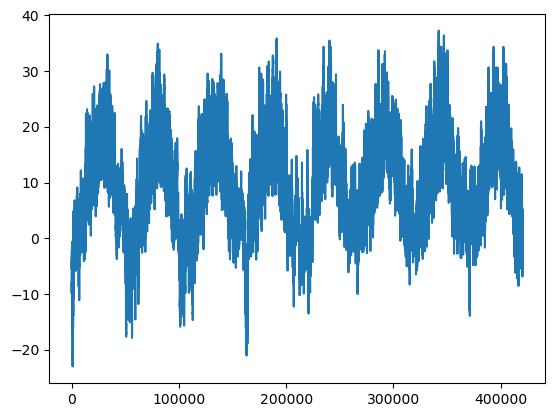

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

### Listing 13.4 Plotting the first 10 days of the temperature timeseries

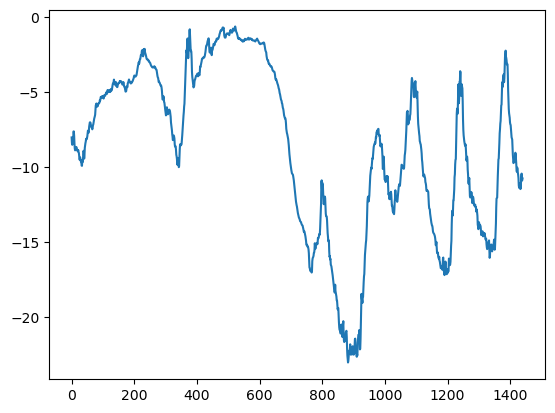

In [4]:
plt.plot(range(1440), temperature[:1440])

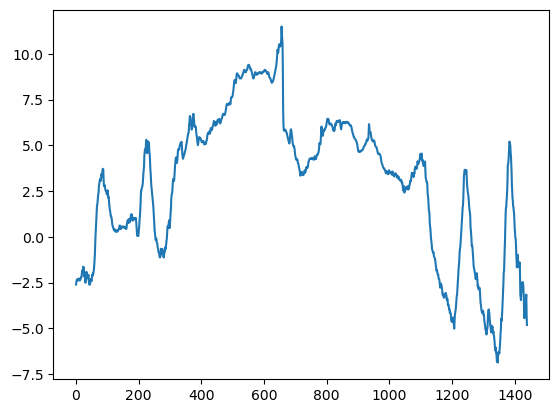

In [5]:
plt.plot(range(1440), temperature[len(temperature)-1440:])

### Listing 13.5 Computing the nuber of samples we'll use for each data split

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Listing 13.6 Normalizing the data

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

### Listing 13.7 Instantiating Datasets for training, validation, and testing

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

2025-06-26 10:17:56.797564: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-26 10:18:02.128779: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Listing 13.8 Inspecting the output of one of our Datasets

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


2025-06-26 10:18:04.168412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2025-06-26 10:18:04.168626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [209506]
	 [[{{node Placeholder/_8}}]]


### Listing 13.9 Computing the common-sense baseline MAE

In [10]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1] #1
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2025-06-26 10:18:05.688018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [105112]
	 [[{{node Placeholder/_20}}]]
2025-06-26 10:18:05.688256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


Validation MAE: 2.44


2025-06-26 10:18:06.940364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [104256]
	 [[{{node Placeholder/_20}}]]
2025-06-26 10:18:06.940606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [104256,14]
	 [[{{node Placeholder/_0}}]]


Test MAE: 2.62


### Listing 13.10 Training and evaluating a densely connected model

In [11]:
import keras
from keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 4s 5ms/step - loss: 14.7704 - mae: 2.9137 - val_loss: 10.7543 - val_mae: 2.5946
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 9.1735 - mae: 2.3851 - val_loss: 10.9130 - val_mae: 2.6168
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 8.4519 - mae: 2.2879 - val_loss: 10.9082 - val_mae: 2.6186
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 7.8685 - mae: 2.2072 - val_loss: 11.4106 - val_mae: 2.6580
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 7.3696 - mae: 2.1385 - val_loss: 11.6160 - val_mae: 2.6803
Epoch 6/10
819/819 [==============================] - 5s 6ms/step - loss: 7.0339 - mae: 2.0907 - val_loss: 11.7009 - val_mae: 2.7056
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 6.8002 - mae: 2.0561 - val_loss: 12.0687 - val_mae: 2.7382
Epoch 8/10
819/819 [==============================] - 4s 5ms/step - 

### Listing 13.11 Plotting results

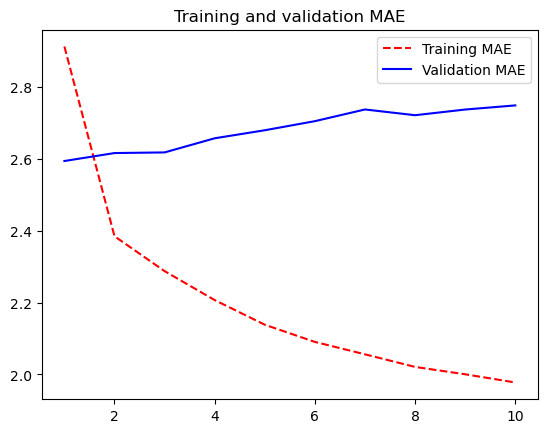

In [12]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Listing 13.12 A simple LSTM-based model

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")

Epoch 1/10


2025-06-26 10:20:36.380584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 10:20:36.381094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 10:20:36.381564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

819/819 [==============================] - ETA: 0s - loss: 47.8359 - mae: 5.1117    

2025-06-26 10:20:58.218738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 10:20:58.219423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 10:20:58.219937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

819/819 [==============================] - 27s 32ms/step - loss: 47.8359 - mae: 5.1117 - val_loss: 18.7364 - val_mae: 3.2161
Epoch 2/10
819/819 [==============================] - 26s 31ms/step - loss: 15.0351 - mae: 2.9293 - val_loss: 11.7589 - val_mae: 2.6215
Epoch 3/10
819/819 [==============================] - 27s 33ms/step - loss: 11.4057 - mae: 2.6073 - val_loss: 10.4502 - val_mae: 2.5064
Epoch 4/10
819/819 [==============================] - 30s 37ms/step - loss: 10.2388 - mae: 2.4838 - val_loss: 10.0865 - val_mae: 2.4728
Epoch 5/10
819/819 [==============================] - 31s 38ms/step - loss: 9.5830 - mae: 2.4035 - val_loss: 9.9254 - val_mae: 2.4573
Epoch 6/10
819/819 [==============================] - 32s 40ms/step - loss: 8.9795 - mae: 2.3337 - val_loss: 9.8550 - val_mae: 2.4378
Epoch 7/10
819/819 [==============================] - 31s 37ms/step - loss: 8.6193 - mae: 2.2913 - val_loss: 9.9604 - val_mae: 2.4516
Epoch 8/10
819/819 [==============================] - 31s 38ms/st

2025-06-26 10:25:34.078935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 10:25:34.079629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 10:25:34.080112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
print(f"Test Loss: {model.evaluate(test_dataset)[0]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

  1/405 [..............................] - ETA: 1:49 - loss: 9.9699 - mae: 2.5334

2025-06-26 10:26:15.284170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 10:26:15.284802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 10:26:15.285511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

405/405 [==============================] - 7s 17ms/step - loss: 10.8568 - mae: 2.5776
Test Loss: 10.86
405/405 [==============================] - 5s 13ms/step - loss: 10.8568 - mae: 2.5776
Test MAE: 2.58


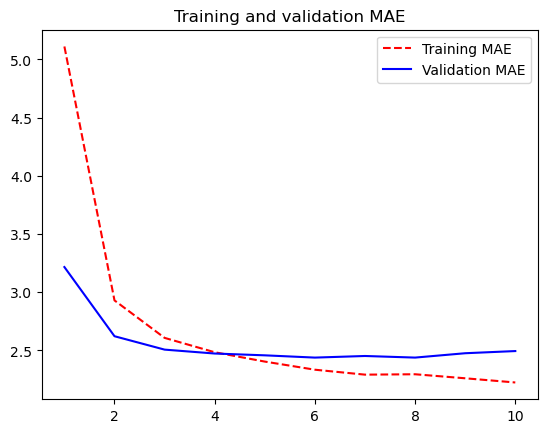

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# Model Prediction

In [16]:
pred = model.predict(test_dataset)
print('\nPredicted Values:\n', pred)
print(f'Number of values in prediction: {len(pred)}')

  1/405 [..............................] - ETA: 1:38

2025-06-26 10:26:33.361578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 10:26:33.362342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 10:26:33.362923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

405/405 [==============================] - 6s 13ms/step

Predicted Values:
 [[ 9.6551695]
 [16.576643 ]
 [ 4.2954497]
 ...
 [10.306021 ]
 [ 2.38335  ]
 [ 2.003032 ]]
Number of values in prediction: 103537


### Plot of Predicted values 

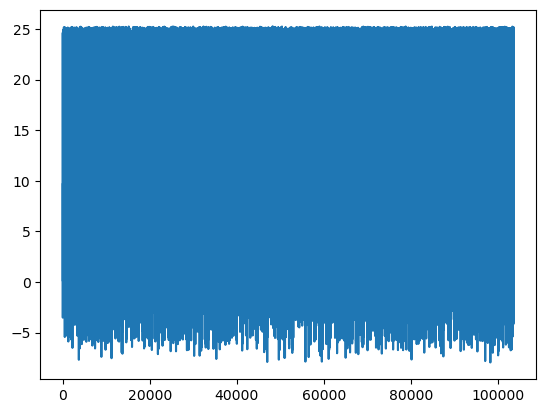

In [17]:
plt.plot(range(len(pred)), pred)

### Plotting first 1440 Predicted values 

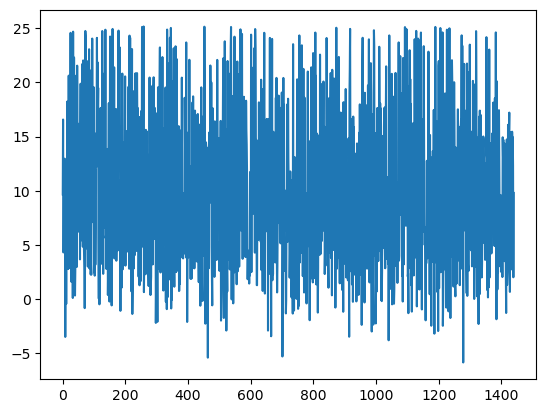

In [18]:
plt.plot(range(1440), pred[:1440])

In [19]:
eva = model.evaluate(test_dataset)
print('\Loss Values:\n', eva[0])
print('\Metrics Values:\n', eva[1])

405/405 [==============================] - 6s 13ms/step - loss: 10.8568 - mae: 2.5776
\Loss Values:
 10.856837272644043
\Metrics Values:
 2.5775721073150635


### Listing 13.15 NumPy implementation of a simple RNN

In [20]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

### Listing 13.16 A RNN layer that can process sequences of any length

In [21]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

### Listing 13.17 A RNN layer that returns only its last output step

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


### Listing 13.18 A RNN layer that returns its full output sequence

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


### Listing 13.19 Stacking RNN layers

In [24]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

# 13.10 Using recurrent dropout to fight overfitting

### Listing 13.22 Training and evaluating a dropout-regularized LSTM

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_lstm_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/50
819/819 [==============================] - 89s 108ms/step - loss: 31.7644 - mae: 4.1684 - val_loss: 11.5078 - val_mae: 2.5859
Epoch 2/50
819/819 [==============================] - 92s 112ms/step - loss: 16.1566 - mae: 3.1116 - val_loss: 9.9740 - val_mae: 2.4500
Epoch 3/50
819/819 [==============================] - 94s 115ms/step - loss: 14.7148 - mae: 2.9747 - val_loss: 9.6262 - val_mae: 2.4138
Epoch 4/50
819/819 [==============================] - 91s 111ms/step - loss: 13.9378 - mae: 2.8904 - val_loss: 9.3941 - val_mae: 2.3862
Epoch 5/50
819/819 [==============================] - 91s 111ms/step - loss: 13.4252 - mae: 2.8340 - val_loss: 9.6902 - val_mae: 2.4160
Epoch 6/50
819/819 [==============================] - 88s 107ms/step - loss: 12.8888 - mae: 2.7754 - val_loss: 9.4031 - val_mae: 2.3740
Epoch 7/50
819/819 [==============================] - 89s 109ms/step - loss: 12.5263 - mae: 2.7362 - val_loss: 9.4621 - val_mae: 2.3835
Epoch 8/50
819/819 [===========================

## Plotting model prediction

In [25]:
pred = model.predict(test_dataset)
print('\nPredicted Values:\n', pred)
print(f'Number of values in prediction: {len(pred)}')

405/405 [==============================] - 13s 33ms/step

Predicted Values:
 [[ 2.095934 ]
 [15.460842 ]
 [ 4.8143578]
 ...
 [10.026806 ]
 [18.525406 ]
 [ 7.131484 ]]
Number of values in prediction: 103537


## All predicted values

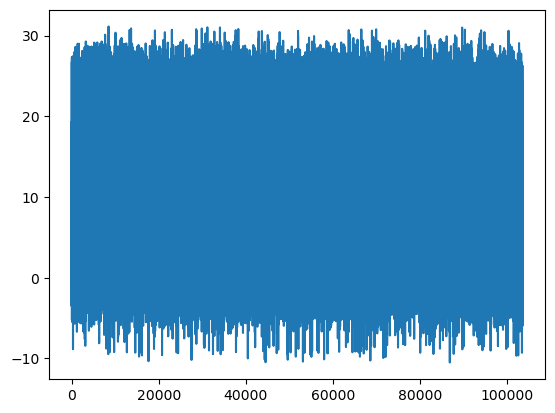

In [26]:
plt.plot(range(len(pred)), pred)

## First 1440 predicted values

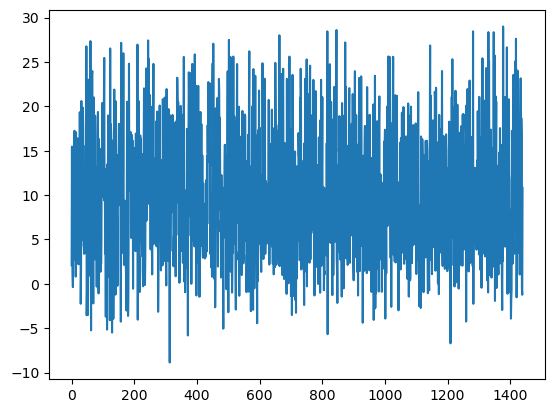

In [27]:
plt.plot(range(1440), pred[:1440])

### Listing 13.23 Training and evaluating a dropout-regularized, stacked GRU model

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "jena_stacked_gru_dropout.keras", save_best_only=True
    )
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 191s 231ms/step - loss: 28.8246 - mae: 3.9477 - val_loss: 10.7182 - val_mae: 2.4743
Epoch 2/50
819/819 [==============================] - 191s 234ms/step - loss: 14.7865 - mae: 2.9697 - val_loss: 9.8005 - val_mae: 2.4190
Epoch 3/50
819/819 [==============================] - 189s 231ms/step - loss: 13.7974 - mae: 2.8691 - val_loss: 9.2167 - val_mae: 2.3492
Epoch 4/50
819/819 [==============================] - 189s 230ms/step - loss: 13.3500 - mae: 2.8190 - val_loss: 9.4208 - val_mae: 2.3819
Epoch 5/50
819/819 [==============================] - 185s 226ms/step - loss: 12.8345 - mae: 2.7677 - val_loss: 9.2606 - val_mae: 2.3646
Epoch 6/50
819/819 [==============================] - 189s 231ms/step - loss: 12.3672 - mae: 2.7179 - val_loss: 9.2217 - val_mae: 2.3662
Epoch 7/50
819/819 [==============================] - 187s 228ms/step - loss: 11.8902 - mae: 2.6672 - val_loss: 9.8452 - val_mae: 2.4474
Epoch 8/50
819/819 [====================

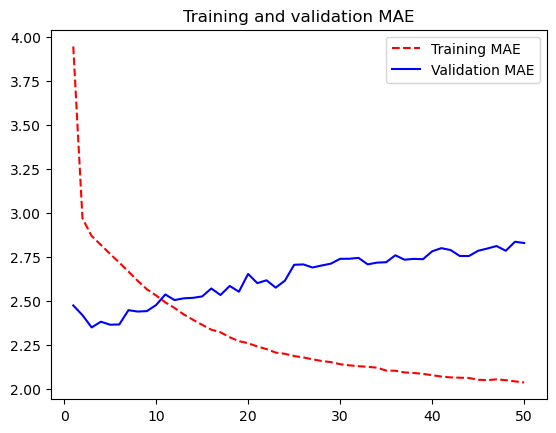

In [32]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Plotting model prediction

In [29]:
pred = model.predict(test_dataset)
print('\nPredicted Values:\n', pred)
print(f'Number of values in prediction: {len(pred)}')

405/405 [==============================] - 28s 69ms/step

Predicted Values:
 [[12.849938 ]
 [17.377039 ]
 [ 7.3173547]
 ...
 [12.839495 ]
 [16.014084 ]
 [ 2.5604954]]
Number of values in prediction: 103537


## All predicted values

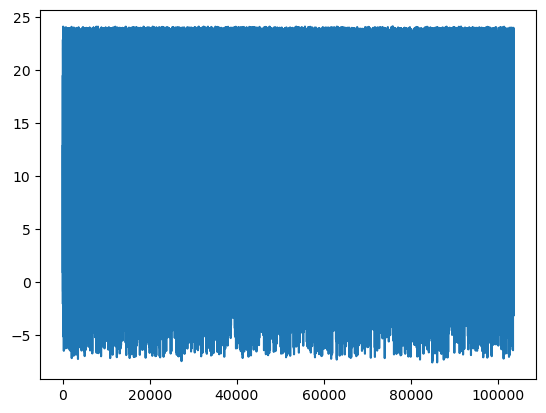

In [30]:
plt.plot(range(len(pred)), pred)

## First 1440 predicted values

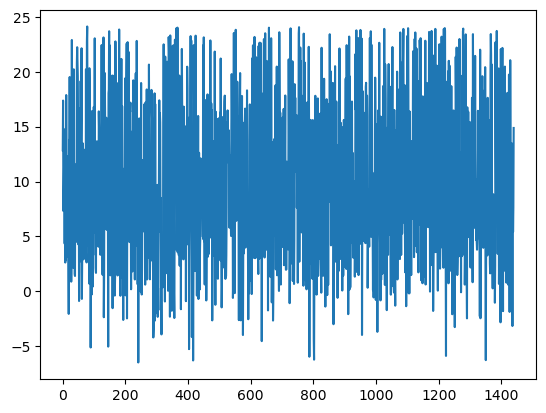

In [31]:
plt.plot(range(1440), pred[:1440])

### Listing 13.24 Training and evaluating a bidirectional LSTM

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
)

Epoch 1/10


2025-06-26 14:52:16.165856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 14:52:16.166450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 14:52:16.166879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

819/819 [==============================] - ETA: 0s - loss: 32.9164 - mae: 4.1500     

2025-06-26 14:52:54.151025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 14:52:54.151881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 14:52:54.152549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

819/819 [==============================] - 45s 54ms/step - loss: 32.9164 - mae: 4.1500 - val_loss: 12.2558 - val_mae: 2.6698
Epoch 2/10
819/819 [==============================] - 47s 58ms/step - loss: 11.7476 - mae: 2.6681 - val_loss: 10.4925 - val_mae: 2.5103
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 10.0568 - mae: 2.4738 - val_loss: 9.6685 - val_mae: 2.4253
Epoch 4/10
819/819 [==============================] - 53s 64ms/step - loss: 9.1830 - mae: 2.3543 - val_loss: 9.6067 - val_mae: 2.4222
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 8.4457 - mae: 2.2584 - val_loss: 9.8578 - val_mae: 2.4519
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 8.0969 - mae: 2.2124 - val_loss: 10.0049 - val_mae: 2.4508
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 7.6673 - mae: 2.1556 - val_loss: 10.2080 - val_mae: 2.4840
Epoch 8/10
819/819 [==============================] - 51s 62ms/ste

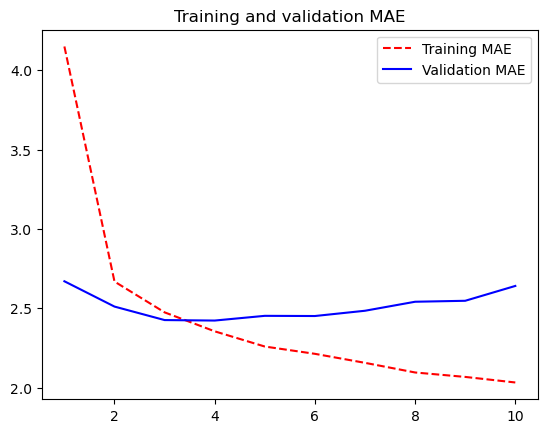

In [34]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [35]:
pred = model.predict(test_dataset)
print('\nPredicted Values:\n', pred)
print(f'Number of values in prediction: {len(pred)}')

2025-06-26 15:11:49.905864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-06-26 15:11:49.906847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-06-26 15:11:49.907465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

405/405 [==============================] - 8s 18ms/step

Predicted Values:
 [[ 4.570524]
 [15.296139]
 [21.240335]
 ...
 [17.091022]
 [ 6.632125]
 [ 6.587072]]
Number of values in prediction: 103537


# First 24 hours

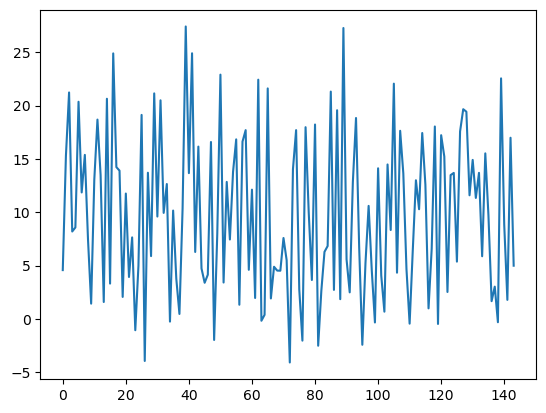

In [36]:
plt.plot(range(144), pred[:144])

# Last 24 hours

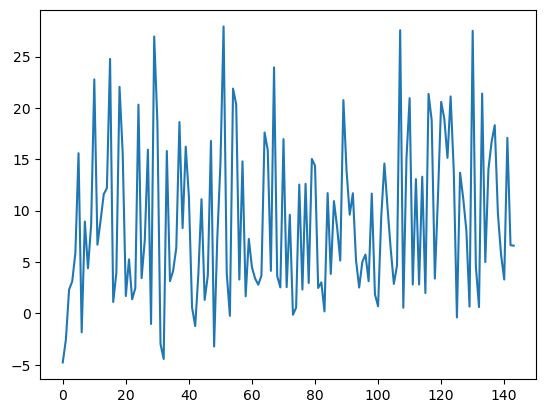

In [37]:
plt.plot(range(144), pred[len(pred)-144:])